In [26]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
load_dotenv()

True

In [35]:
# define my llm 
llm_model = ChatOpenAI(model="gpt-3.5-turbo")

# sentiment output schema for llm
class SentimentSchema(BaseModel):
    sentiment : Literal["positive", "negative"] = Field(description="The sentiment of the review")

# diagnosis output schema for llm
class ReviewDiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

structured_llm = llm_model.with_structured_output(SentimentSchema)
structured_llm2 = llm_model.with_structured_output(ReviewDiagnosisSchema)

d:\hobby projects\python\langGraph_practice\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1928: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [36]:
# define state class
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    review_diagnosis: dict
    response: str

In [ ]:
# define node functions
def sentiment_analysis(state: ReviewState):
    user_review = state['review']
    prompt = f"Find the sentiment of the following review: {user_review}"
    review_sentiment = structured_llm.invoke(prompt).sentiment
    
    return {'sentiment' : review_sentiment}

def positive_response(state: ReviewState):
    sentiment = state['sentiment']
    response = llm_model.invoke("write a thank you message to the user as this review sentiment is {sentiment} and say kindly to stay with us")
    return {"response": response}

def review_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this {state['sentiment']} sentiment review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_llm2.invoke(prompt)
    return {"review_diagnosis" : response.model_dump()}

def negative_response(state: ReviewState):
    diagnosis = state['review_diagnosis']
    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = llm_model.invoke(prompt)
    return {"response": response}

# define conditional function
def choose_response(state: ReviewState) -> Literal["positive_response", "review_diagnosis"]:
    if state['sentiment'] == "positive":
        return "positive_response"
    else:
        return "review_diagnosis"

In [38]:
# define nodes
graph = StateGraph(ReviewState)
graph.add_node("sentiment_analysis", sentiment_analysis)
graph.add_node("positive_response", positive_response)
graph.add_node("review_diagnosis", review_diagnosis)
graph.add_node("negative_response", negative_response)

# define edges
graph.add_edge(START, "sentiment_analysis")
graph.add_conditional_edges("sentiment_analysis", choose_response)
graph.add_edge("positive_response", END)
graph.add_edge("review_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

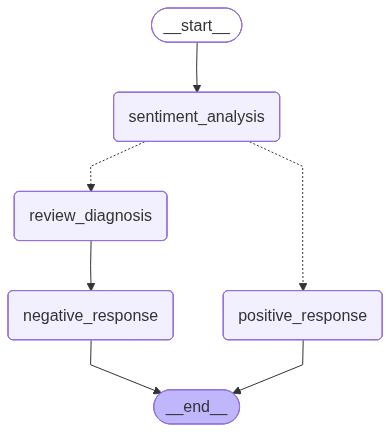

In [39]:
# make the workflow
workflow = graph.compile()
workflow

In [ ]:
initial_state1 = {"review": "I had a great experience with your Software. It is incredibly user-friendly and intuitive. The UI stood out to me and has made my [work/life] so much easier. Highly recommended!"}
initial_state2 = {"review": "I've been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."}
workflow.invoke(initial_state2)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'review_diagnosis': {'issue_type': 'Bug',
  'tone': 'frustrated',
  'urgency': 'high'},
 'response': AIMessage(content="I'm so sorry to hear that you're experiencing a bug issue and feeling frustrated. I completely understand how that can be incredibly frustrating. \n\nPlease know that I am here to help and will do everything I can to resolve this issue for you as quickly as possible. Can you please provide me with more details about the bug you're encountering so that I can better assist you? \n\nYour urgency has been noted as high, and I will prioritize this issue accordingly. Thank you for bringing it to my attention, and I will work to resolve it as soon as possible. \n\nHang in there, and thank you for your patien